# Project Final Report: Hours Played vs. Likelihood to Subscribe

### Names, student #:

- Cohen Prescod, 67109181
- Jeda Welle, 73383788
- Philip Jiang, 71930762


A research group at UBC, led by Frank Wood set up a Minecraft server and recorded the actions and various observations of players. They need to target their recruitment efforts and make sure they have enough resources to accommodate the number of players they attract.

**Players.csv**: A list of all unique players, 196 rows, 7 columns, includes variables:
- **experience**: character, shows how familiar a play is with the game
    - includes entries: amateur, beginner, regular, veteran, and pro.
- **subscribe**: logical, yes or no for if the player subscribed to the newsletter
- **hashedEmail**: character, string of characters that privately identify specific players' emails
- **played_hours**: Decimal Values, amount of time (hours) spent playing on this server
- **name**: character, name of player
- **gender**: character, gender of player
    - Consists of entries: male, female, non-binary, prefer not to say, two-spirited, Agender, and other.
- **age**: Decimal Values, age of player

## Questions

**Broad**: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Specific**: Can the number of hours played and a players age predict subscription in player.csv?

**Justification**:
- The only two quantitative variables in data set are "age" and "played_hours", no tangible reason to discard either predictor
- Other variables are all categorical, have not learned how to do this kind of classification in class
- Possible relationship between "played_hours" and like\lihood to "subscribe"
- Possible relationship between "played_hours" and likelihood to "subscribe"
- Many players who played 0 hours, may skew data, good to keep in mind

In [251]:
library(tidyverse)
library(repr)
library(tidymodels)

Read in the dataset!!!

In [252]:
players_URL<-"https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
players<-read_csv(players_URL)
head(players)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


### Wrangling the data:
- Renamed variables for consistancy
- Removed all NAs (so they don't skew data)
- Changed subscribe into a factor (allows this to be used as a response variable in classification later)

In [253]:
players<- players|>
    rename(hashed_email=hashedEmail)|>
    mutate(subscribe=as.factor(subscribe))|>
    select(experience,subscribe,hashed_email,played_hours,name,gender,age)|>
    drop_na()|>
    select(subscribe, played_hours,age)

head(players)

subscribe,played_hours,age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


## Summary statistics

**subscribe**:
- Most players subscribed (74%, about a 3:1 ratio of players subscribed to not subscribed)

In [254]:
subscribe_count<- players|>
    count(subscribe)|>
    mutate(percent = n / sum(n) *100) |>
    arrange(desc(n))
subscribe_count

subscribe,n,percent
<fct>,<int>,<dbl>
TRUE,144,73.46939
FALSE,52,26.53061


**played_hours**:
- High number of players playing 0 hours raises a concern, possibly skewing statistics like mean and sd
- Large range of time played (0-223.1)
- Mean is 5.85 (on lower end)
- SD 28.36 hours (high deviation, varrying interest in game)

In [255]:
played_hours_count<-players|>
    count(played_hours)|>
    arrange(desc(n))
head(played_hours_count)

played_hours_min<-players|>
    summarize(min_played_hours=min(played_hours))
played_hours_min

played_hours_max<-players|>
    summarize(max_played_hours=max(played_hours))
played_hours_max

played_hours_mean<-players|>
    summarize(mean_played_hours=mean(played_hours,na.rm=TRUE))|>
    round(digits=2)
played_hours_mean

played_hours_sd<-players|>
    summarize(standard_deviation_played_hours=sd(played_hours,na.rm=TRUE))|>
    round(digits=2)
played_hours_sd

played_hours,n
<dbl>,<int>
0.0,85
0.1,34
0.2,10
1.0,6
0.3,5
0.4,5


min_played_hours
<dbl>
0


max_played_hours
<dbl>
223.1


mean_played_hours
<dbl>
5.85


standard_deviation_played_hours
<dbl>
28.36


**age**:
- 8-99 years old, standard deviation 9.71(wide variation of ages playing)
- Mean age about 21(younger end)

In [256]:
age_count<-players|>
    count(age)|>
    arrange(desc(n))
head(age_count)

age_min<-players|>
    summarize(min_age=min(age,na.rm=TRUE))
age_min

age_max<-players|>
    summarize(max_age=max(age,na.rm=TRUE))
age_max

age_mean<-players|>
    summarize(mean_age=mean(age,na.rm=TRUE))|>
    round(digits=2)
age_mean

age_sd<-players|>
    summarize(standard_deviation_age=sd(age,na.rm=TRUE))|>
    round(digits=2)

age_sd

age,n
<dbl>,<int>
17,75
21,18
22,15
20,14
23,13
24,10


min_age
<dbl>
8


max_age
<dbl>
99


mean_age
<dbl>
21.28


standard_deviation_age
<dbl>
9.71


## Exploratory Data Analysis and Visualization
- Unclear correlation between the age of a player and hours played (game appeals somewhat equally to all ages)
- Possible positive relationship between played hours and subscription (as hours played increase, subscriptions increase (people not subscribing decrease))
- Possible but unclear positive relationship between age and subscription

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


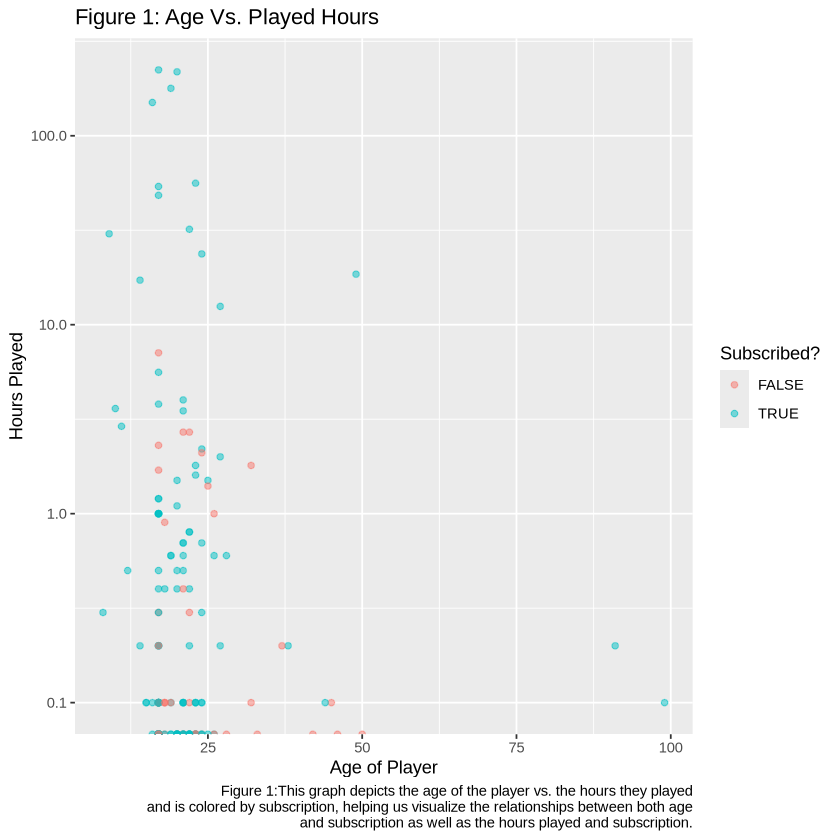

In [248]:
age_vs_played_hours <- players|>
    ggplot(aes(x=age, y=played_hours, color= subscribe))+
        geom_point(alpha=0.5) +
        scale_y_log10() +
        labs(x="Age of Player", y="Hours Played", color="Subscribed?", caption = "Figure 1:This graph depicts the age of the player vs. the hours they played
and is colored by subscription, helping us visualize the relationships between both age
and subscription as well as the hours played and subscription.")+
        ggtitle("Figure 1: Age Vs. Played Hours")

age_vs_played_hours


## Hours Played by Subscription Status

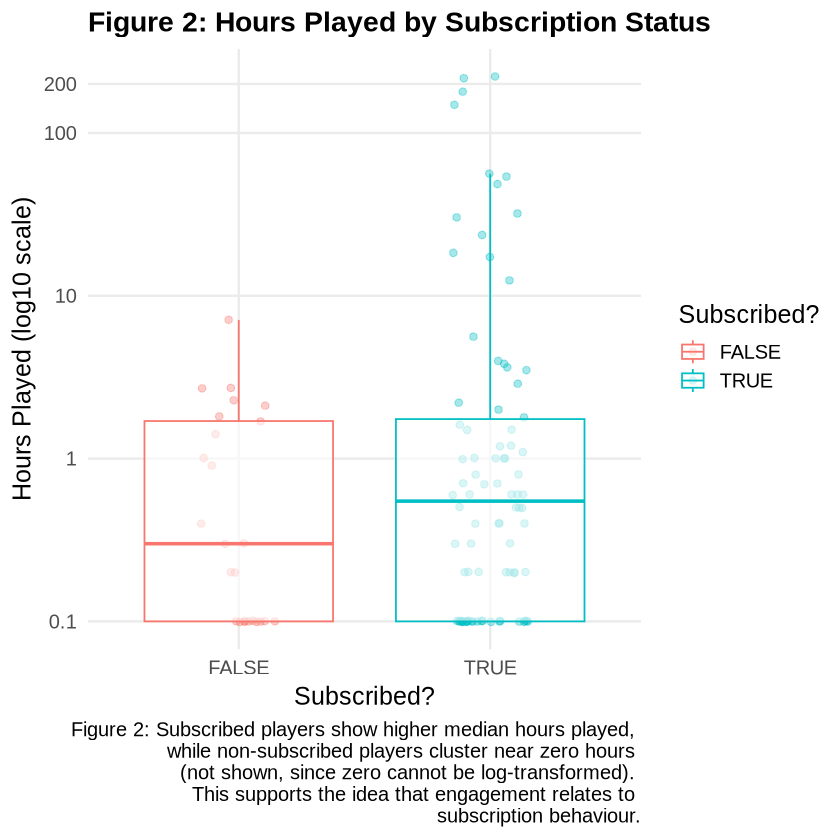

In [249]:
p_sub_box <- players |>
  filter(played_hours > 0) |>
  ggplot(aes(x = subscribe, y = played_hours, color = subscribe)) +
  geom_jitter(width = 0.15, alpha = 0.35, size = 1.8) +
  geom_boxplot(alpha = 0.6, outlier.shape = NA) +
  scale_y_log10(
    breaks = c(0.1, 1, 10, 100, 200),
    labels = c("0.1", "1", "10", "100", "200")
  ) +
  labs(
    title = "Figure 2: Hours Played by Subscription Status",
    x = "Subscribed?",
    y = "Hours Played (log10 scale)",
    color = "Subscribed?",
    caption = "Figure 2: Subscribed players show higher median hours played, 
      while non-subscribed players cluster near zero hours 
    (not shown, since zero cannot be log-transformed). 
      This supports the idea that engagement relates to 
      subscription behaviour."
  ) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(face = "bold", size = 17),
    panel.grid.minor = element_blank()
  )

p_sub_box


## Distribution of Hours Played

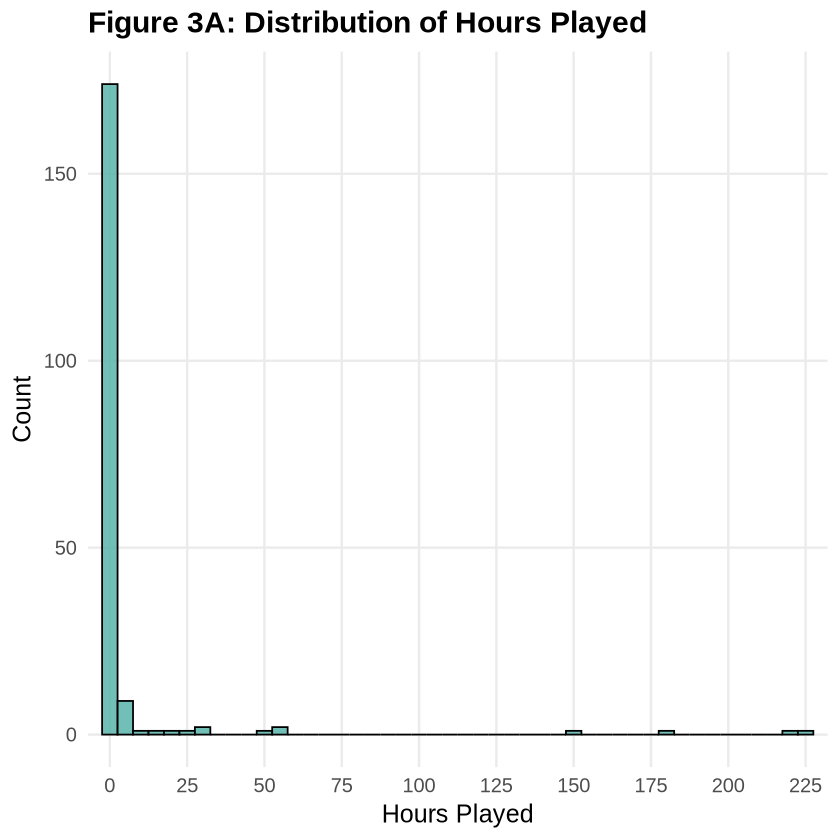

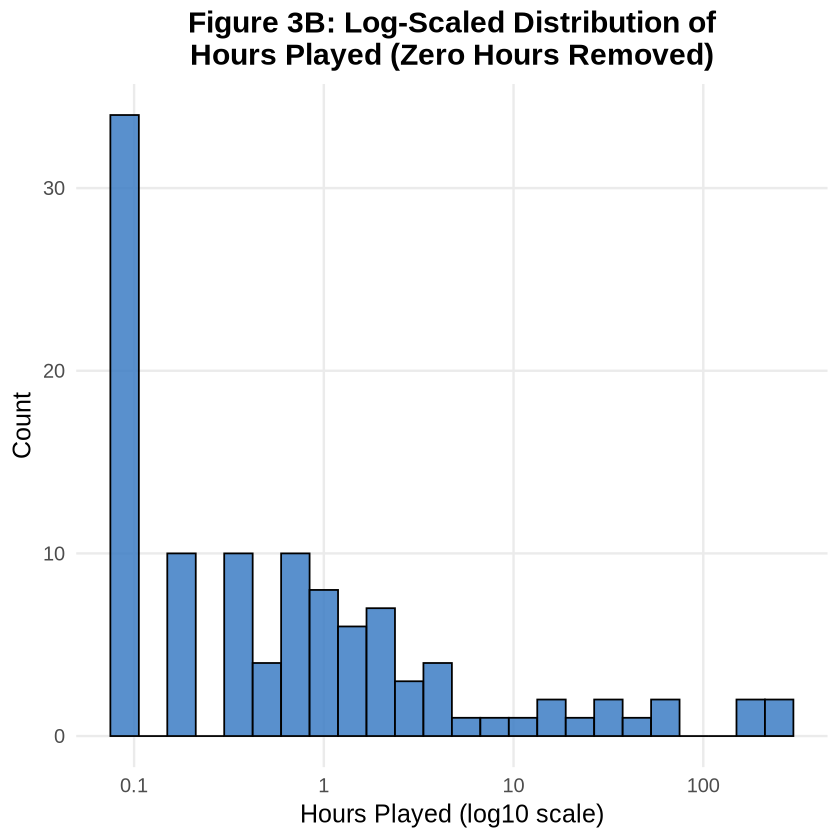

In [250]:
p_raw <- players |>
  ggplot(aes(x = played_hours)) +
  geom_histogram(binwidth = 5, fill = "#5ab4ac",
                 color = "black", alpha = 0.85) +
  scale_x_continuous(
    breaks = seq(0, 225, by = 25),
    expand = expansion(mult = 0.02)
  ) +
  labs(
    title = "Figure 3A: Distribution of Hours Played",
    x = "Hours Played",
    y = "Count"
  ) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    panel.grid.minor = element_blank()
  )

p_log <- players |>
  filter(played_hours > 0) |>
  ggplot(aes(x = played_hours)) +
  geom_histogram(binwidth = 0.15, fill = "#3c7dc4", color = "black", alpha = 0.85) +
  scale_x_log10(
    breaks = c(0.1, 1, 10, 100),
    labels = c("0.1", "1", "10", "100")
  ) +
  labs(
    title = "Figure 3B: Log-Scaled Distribution of\nHours Played (Zero Hours Removed)",
    x = "Hours Played (log10 scale)",
    y = "Count"
  ) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(face = "bold", size = 18, hjust = 0.5),
    panel.grid.minor = element_blank()
  )

p_raw
p_log


## Summary of Exploratory Data Analysis and Visualization

Our exploratory analysis shows that hours played is the only predictor with a meaningful relationship to subscription behavior. The distribution of playtime is extremely right-skewed, with around 85 players recording zero hours (see Figures 3A and 3B), which pulls the mean downward and creates a large cluster at the lower bound. After applying a log scale, we observe that subscribers are more likely to have played for longer periods, while non-subscribers remain concentrated near zero. This pattern indicates that engagement with the game is associated with a higher likelihood of subscribing.

In contrast, age shows little to no relationship with the amount of time a player spends in the game (Figure 1). Players of different ages exhibit similar ranges of playtime, and the log-scaled scatterplot confirms that subscription trends do not vary systematically across age groups. This suggests that age is not a useful predictor of subscription and contributes limited information to the model.

## KNN Classification Model
This question requires a K-Nearest Neighbours Classification Model to predict if a observation will be subscribed or not. The predictors used will be the numeric variables, age and played hours. To create the best possible model we will use cross validation, split 75% into a training set and 25% into a testing set, with 10 folds. I chose 10 folds due to the realtivly small size of the dataset. Using more folds ensures the best k found is more reliabile and applicable to data in general, not just the training set. After finding the best K, I used this on the unseen testing set, and found both the accuracy of the model as well as a confusion matrix of the results.

[1] 6

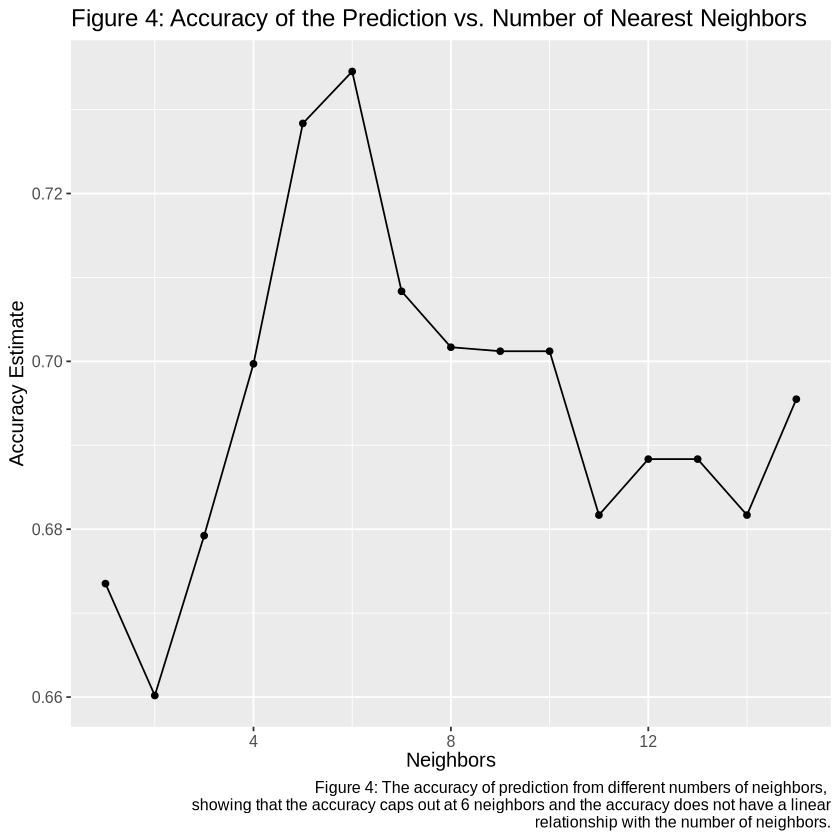

In [257]:
set.seed(2025)

player_split <- initial_split(players, prop = 0.75)
player_train <- training(player_split)
player_test  <- testing(player_split)

player_vfold <- vfold_cv(player_train, v = 10, strata = subscribe)

player_recipe <- recipe(subscribe ~ played_hours + age, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

player_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(1:15))

knn_results <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_model) |>
  tune_grid(resamples = player_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")


accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title= "Figure 4: Accuracy of the Prediction vs. Number of Nearest Neighbors", caption= "Figure 4: The accuracy of prediction from different numbers of neighbors, 
showing that the accuracy caps out at 6 neighbors and the accuracy does not have a linear
relationship with the number of neighbors.") +
  theme(text = element_text(size = 12))

accuracy_vs_k

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k


In [206]:
set.seed(2025)

player_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
  set_engine("kknn") |>
  set_mode("classification")

player_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_model) |>
  fit(data = player_train)

player_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3061224
Best kernel: rectangular
Best k: 6

In [207]:
set.seed(2025)


player_test_predictions <- predict(player_fit, player_test) |>
  bind_cols(player_test)

player_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

confusion <- player_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)

head(player_test_predictions)
confusion



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6938776


.pred_class,subscribe,played_hours,age
<fct>,<fct>,<dbl>,<dbl>
TRUE,FALSE,0.0,17
TRUE,TRUE,0.0,19
TRUE,TRUE,0.1,17
TRUE,TRUE,0.0,17
TRUE,FALSE,0.1,17
TRUE,FALSE,0.0,33


          Truth
Prediction FALSE TRUE
     FALSE     5    6
     TRUE      9   29

In [142]:
player_test_predictions |> 
    pull(subscribe) |> 
    levels()
player_test_predictions |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "second")

player_test_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "first")

[1] "FALSE" "TRUE"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7631579


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.3571429


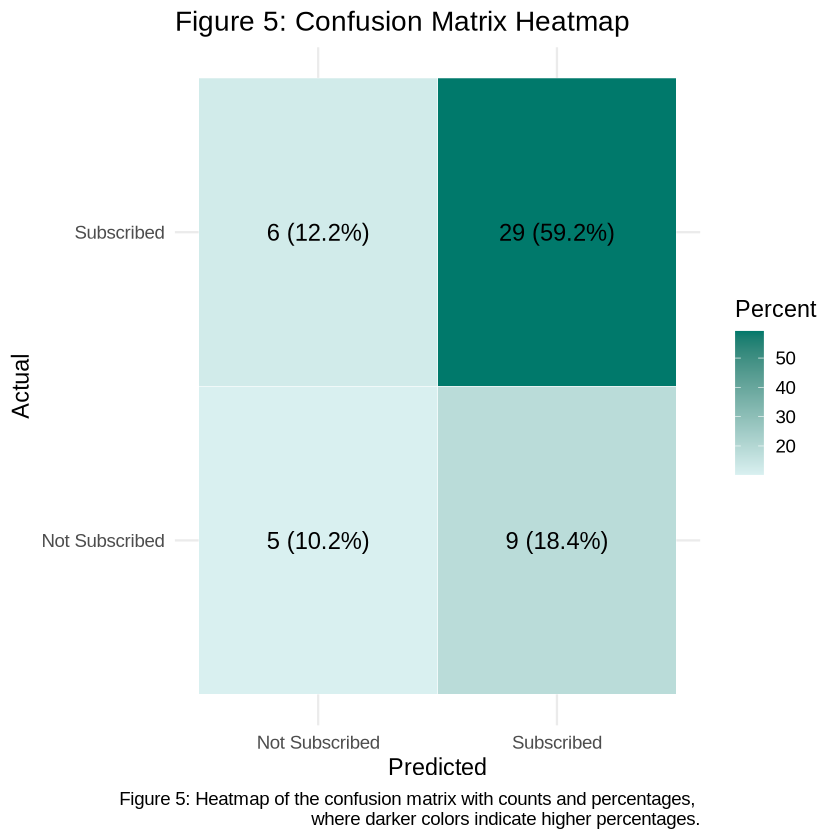

In [258]:
#heatmap created based on stack overflow post by Artyom https://stackoverflow.com/questions/37897252/plot-confusion-matrix-in-r-using-ggplot

confusion_data <- as_tibble(confusion$table)


confusion_data <- confusion_data |>
  mutate( Prediction = factor(Prediction, levels = c(FALSE, TRUE)), Truth = factor(Truth, levels = c(FALSE, TRUE))) |>
    mutate(percent = n / sum(n) *100)

confusion_data <- confusion_data |>
  mutate(label = paste0(n, " (", round(percent, 1), "%)"))


cm_heatmap <- ggplot(confusion_data, aes(x = Prediction, y = Truth, fill = percent)) +
  geom_tile(color = "white") +
  geom_text(aes(label = label), color = "black", size = 5) + 
  scale_fill_gradient(low = "#d9f0f0", high = "#00796b") +    
  labs(title = "Figure 5: Confusion Matrix Heatmap", x = "Predicted", y = "Actual", fill = "Percent", caption = "Figure 5: Heatmap of the confusion matrix with counts and percentages, 
    where darker colors indicate higher percentages.") +
  scale_x_discrete(labels = c("Not Subscribed", "Subscribed")) +
  scale_y_discrete(labels = c("Not Subscribed", "Subscribed")) +
  theme_minimal(base_size = 14) 

cm_heatmap

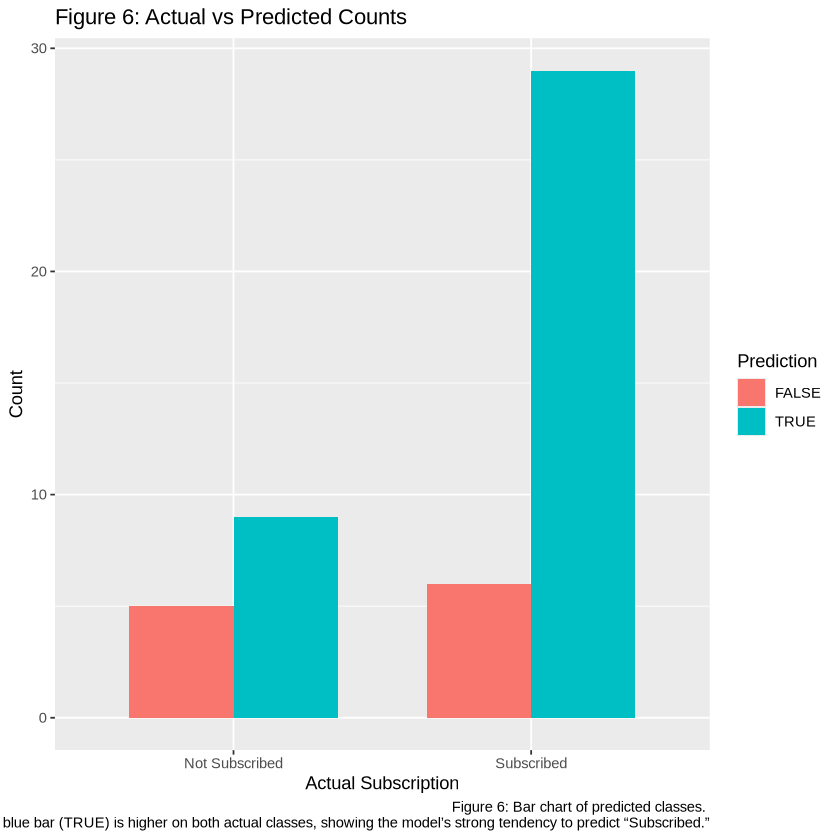

In [259]:
confusion_bar <- ggplot(confusion_data, aes(x = Truth, y = n, fill = Prediction)) +
  geom_col(position = "dodge", width = 0.7) +
  scale_x_discrete(labels = c("Not Subscribed", "Subscribed")) +
  labs(title = "Figure 6: Actual vs Predicted Counts", x = "Actual Subscription", y = "Count", fill = "Prediction", caption = "Figure 6: Bar chart of predicted classes. 
    Notice the blue bar (TRUE) is higher on both actual classes, showing the model’s strong tendency to predict “Subscribed.”") 

confusion_bar

As shown in Figure 4, the KNN model shows its highest accuracy at around k = 6–9, reaching roughly 72-73% during cross-validation. This pattern indicates that small values of k tend to overfit, while large values underfit, flattening accuracy near 69%. Even at its best, the model’s accuracy remains modest, potentially due to the small and heavily imbalanced dataset, with far more subscribed than non-subscribed players. KNN Classification models generally favour the majority class when predicting, especially if the majority is much larger. On first glance the model performs better than random guessing, but looking at the confusion matrix (vizualized in Figures 5 and 6) it shows that in reality the model just predicted "subscribed" (TRUE) much more often (about 80% of the time). The models accuracy is actually lower than the majority classifier found earlier, so if the model just randomly predicted "subscribed" 100% of the time it would already have a better accuracy of  roughly 75% compared to the 69% in our model. 

Precision and recall can further highlight this limitation. The model’s precision for subscribers is 75%, but its recall for non-subscribed players is only 35.7%, meaning it misses most of the minority class. Figure 4 shows that it only predicted Not-Subscribed and it was correct 10% of the time, compared to predicting Subscribed and it being correct 60%. These metrics show that although the accuracy of 69% is decent, the model is not at all good at truly predicting subscription class, and instead just mainly succeeded by predicting the majority class. This suggests that the predictors we used of age and hours played carry only weak value for predicting subscription. This aligns with the exploratory analysis: hours played has some relationship to subscription, while age contributes little. 

Additionally, the best k value for the model fluctuates a lot between runs when changing seed due to the small size of the dataset and random splits in cross-validation. This means that while k = 6–9 looks optimal in this seed, in others the best k was found to be 3, 10 or even 15 and the neighbours graph (Figure 4) looked vastly different. This indicates the best k value isn’t a very stable or reliable choice and may not actually be the best k value for the testing set and future data.

Overall, the KNN results reinforce that engagement (hours played) matters more than demographics (age), but the available variables are not strong enough to build a reliable classifier. However, it is also possible that the variables are strong predictors and the imbalanced data set causes the relatively weak accuracy. We can test this by creating another model oversampling the minority class (un-subscribed) and comparing results. 

[1] 14

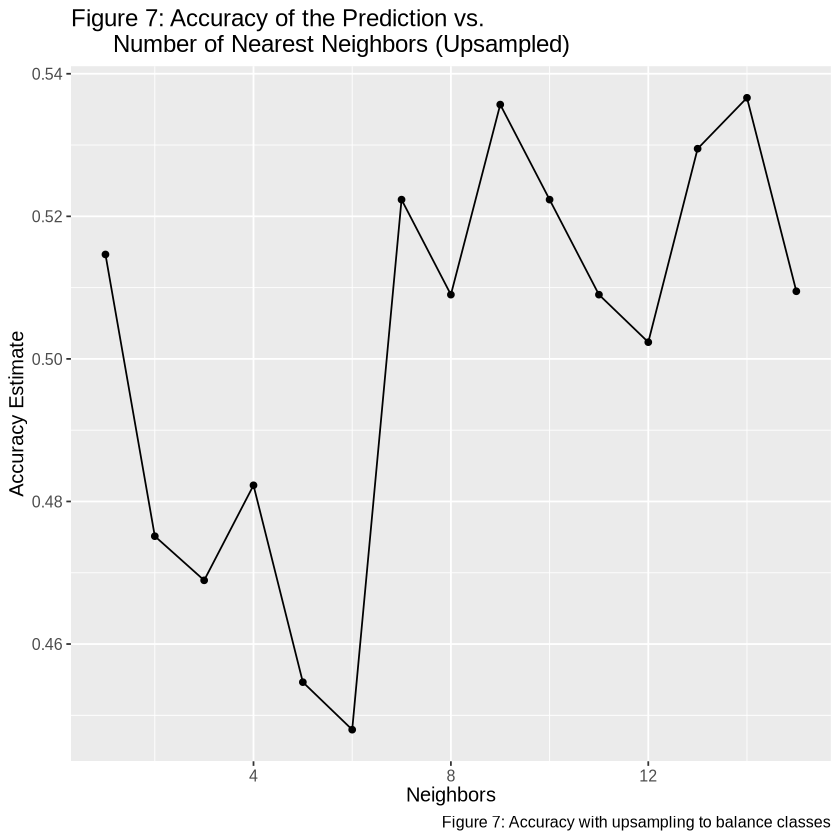

In [261]:
library(themis)

set.seed(2025)

upsample_recipe <- recipe(subscribe ~ played_hours + age, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
  step_upsample(subscribe, over_ratio = 0.75)

player_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_upsample_results <- workflow() |>
  add_recipe(upsample_recipe) |>
  add_model(player_model) |>
  tune_grid(resamples = player_vfold, grid = k_vals) |>
  collect_metrics()

accuracies_upsample <- knn_upsample_results |>
  filter(.metric == "accuracy")

accuracy_vs_k_upsample <- ggplot(accuracies_upsample, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(
    x = "Neighbors", y = "Accuracy Estimate", 
    title= "Figure 7: Accuracy of the Prediction vs. 
      Number of Nearest Neighbors (Upsampled)", 
    caption= "Figure 7: Accuracy with upsampling to balance classes"
  ) +
  theme(text = element_text(size = 12))

best_k_upsample <- accuracies_upsample |>
  arrange(desc(mean)) |>
  head(1) |>
  pull(neighbors)

best_k_upsample
accuracy_vs_k_upsample

In [236]:
set.seed(2025)

upsample_model <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_upsample) |>
  set_engine("kknn") |>
  set_mode("classification")

player_fit <- workflow() |>
  add_recipe(upsample_recipe) |>
  add_model(upsample_model) |>
  fit(data = player_train)

player_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_scale()
• step_center()
• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(14L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4894737
Best kernel: rectangular
Best k: 14

In [237]:
set.seed(2025)


upsample_predictions <- predict(player_fit, player_test) |>
  bind_cols(player_test)

upsample_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

upsample_confusion <- upsample_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)

head(upsample_predictions)
upsample_confusion
upsample_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "first")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4285714


.pred_class,subscribe,played_hours,age
<fct>,<fct>,<dbl>,<dbl>
FALSE,FALSE,0.0,17
FALSE,TRUE,0.0,19
TRUE,TRUE,0.1,17
FALSE,TRUE,0.0,17
TRUE,FALSE,0.1,17
TRUE,FALSE,0.0,33


          Truth
Prediction FALSE TRUE
     FALSE     6   20
     TRUE      8   15

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.4285714


The upsampled model uses an over_ratio of 0.75, which increases the number of non-subscribed players so that the class proportions shift from ~3:1 to ~4:3. As shown in Figure 7, the model found the best k value to be 14, and this value is more consistent (generally always falling between 10-15) across multiple seeds due to the smaller imbalance. With a more balanced dataset the random split of cross-validation folds have less impact on what k yields the best accuracy. In contrast, when an exact 1:1 ratio was used, the best k value almost always returned 1, meaning the model was looking only at direct neighbour and greatly overfit. 

Interestingly, the oversampled models accuracy dropped from the previous K-NN Model to 43%. Meaning, when the number of each class are similar, simply flipping a coin on each observation would lead to better results. This clearly shows the model is very poor and the problems with the accuracy of the KNN model are not due to imbalance in data, but simply **due to the weak predicting power of age and hours played**.  

## Summary of Findings

The K-Nearest Neighbours model shows almost no classification performance, with a best cross-validation accuracy of roughly 72–73% and a test accuracy of 69%. The dataset is heavily imbalanced, with most players subscribed, which inflates the apparent performance when the model predicts the majority class. Precision for subscribed players is moderate, but recall for non-subscribed players is low (~35%), indicating that the model struggles to identify the minority class. Additionally, the optimal value of k varies between runs due to the small dataset and random train/test splits, highlighting the instability of the model. After upsampling the minority class to remove imbalance, the accuracy was further decreased to 43%, worse than random guessing. This is because the model could no longer rely solely on predicting the majority class, revealing the weak predictive power of the variables. This aligns with the exploratory analysis, which found that age contributes little and hours played shows only a weak positive relationship with subscription. Overall, these results suggest that the available predictors of age and hours played carry little information for distinguishing between subscribers and non-subscribers, and that more informative features or a larger, more balanced dataset would be needed to improve predictive performance.

## Did Results Match Expectations?

The results aligned somewhat with what we expected going into the analysis. The exploratory plots (Figures 1, 2, and 3A–3B) implied that hours played would be a somewhat useful prediction variable, The results generally aligned with our expectations. Exploratory plots (Figures 1, 2, and 3A–3B) suggested that hours played might have some predictive value, but the KNN results (Figures 5 and 6) show that overall prediction power is very limited. We anticipated that players who spend more time in the game would be somewhat more likely to subscribe, and the exploratory plots indicated a slight trend in that direction. We expected age to contribute little to the prediction, as there was no theoretical reason to believe that subscription rates would linked with age. The KNN model’s low accuracy aligns with these expectations, though the effect of hours played was weaker than anticipated. It is not entirely clear which predictor contributed more, so hours played may still have had a small positive effect. Overall, the findings demonstrate somewhat less predictive power than initially expected.

## What Is the Impact of These Findings?

These findings have practical implications on the research group. Since subscription cannot be reliably predicted from these features, recruitment and resource planning cannot be optimized based on these variables alone. In other words,  targeting players who spend more time in the game or are a specific age group would likely not improve subscription outcomes. These findings highlight the need for either additional, more informative variables and/or potentially a larger, more balanced dataset to develop predictive models with reliabilty. Without stronger predictors, any model-based strategy for prioritizing server resources or recruitment efforts would be ineffective.

## Limitations

Several limitations limit the strength of our conclusions. The dataset is small, and the heavy skew caused by the large number of zero-hour players reduces the ability to detect subtle patterns in the data. The predictors of age and hours played capture only a narrow slice of player behavior, and the lack of additional features (such as session frequency, in-game actions, or prior engagement history) limits the model’s capacity to explain why players choose to subscribe. While the dataset is heavily imbalanced, experiments with upsampling the minority class show that the low predictive performance is not primarily caused by imbalance, but rather by the limited information contained in the available predictors. Finally, distance-based models like KNN are sensitive to outliers and uneven scaling(as shown in Figure 3A and 3B), making them less robust when predictors are skewed or contain many zeros. These constraints mean the results should be interpreted as preliminary rather than definitive.

## Future Directions

Future work could strengthen these findings by incorporating additional behavioural variables and exploring alternative modeling approaches. More detailed measures of engagement, such as number of sessions, peak concurrent activity, or interaction with specific game features, would likely provide a richer basis for predicting subscription and help capture motivations that just playtime cannot. Addressing class imbalance through resampling techniques or weighted models could improve the classifier’s ability to detect unsubscribed players who might still be receptive to targeted outreach. Another potential improvement would be to collect more observations over time, especially tracking how engagement changes before or after players subscribe. This would allow for stronger causal insights and more reliable predictions.